* Student : NAIT SAADA Thiziri
* MVA 2020

# Deep Learning Assignment

# PART 1 : COMPUTER VISION

In [1]:
import numpy as np 
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as func

import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

matplotlib.style.use('ggplot')
%cd

/root


In [ ]:
latent_dim = 20
# define a simple MLP VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=latent_dim*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_dim, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def generate(self):
      z = torch.normal(0, 1, size=(batch_size, latent_dim)).to(device)
      #random multivariate shape batch size, latent_dim 
      xhat = torch.sigmoid(self.dec1(z))
      return torch.sigmoid(self.dec2(xhat))
 
    def forward(self, x):
        # encoding
        x = torch.sigmoid(self.enc1(x))
        x = self.enc2(x).view(-1, 2, latent_dim)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = torch.sigmoid(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

In [2]:
# leanring parameters
epochs = 100
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# transforms, only converting images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
# train and validation data
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)


## Standard VAE

In [ ]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [6]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    - KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    bce_loss_running = 0.0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        bce_loss_running += bce_loss.item()
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('train bce loss ', bce_loss_running/len(dataloader.dataset))
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader):
    num_rows = 8
    model.eval()
    running_loss = 0.0
    bce_loss_running = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            bce_loss_running += bce_loss.item()
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            #print(dataloader.batch_size)
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                save_image(reconstruction.view(batch_size, 1, 28, 28).cpu(), f"../reconstruction_output{epoch}.png", nrow=num_rows)

        generated_images = model.generate().view(batch_size, 1, 28, 28)
        save_image(generated_images.cpu(), f"../generated_output{epoch}.png", nrow=num_rows)


    print('val bce loss ', bce_loss_running/len(dataloader.dataset))
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [ ]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    print('\n')

Epoch 1 of 100
train bce loss  219.9071289794922
val bce loss  190.32638139648438
Train Loss: 222.9314
Val Loss: 194.6450


Epoch 2 of 100
train bce loss  173.55402423502605
val bce loss  158.7847171875
Train Loss: 181.8435
Val Loss: 169.7160


Epoch 3 of 100
train bce loss  153.09621887207032
val bce loss  147.87158337402343
Train Loss: 164.7374
Val Loss: 160.0691


Epoch 4 of 100
train bce loss  144.51321303710938
val bce loss  138.7234219482422
Train Loss: 157.4569
Val Loss: 152.7289


Epoch 5 of 100
train bce loss  136.28837692871093
val bce loss  132.60383452148437
Train Loss: 150.9823
Val Loss: 147.8305


Epoch 6 of 100
train bce loss  131.78586111653647
val bce loss  128.67643828125
Train Loss: 147.2116
Val Loss: 144.4817


Epoch 7 of 100
train bce loss  127.68460910644531
val bce loss  124.51702346191406
Train Loss: 143.8158
Val Loss: 141.1687


Epoch 8 of 100
train bce loss  124.1869422688802
val bce loss  121.77308549804688
Train Loss: 140.9488
Val Loss: 138.7683


Epoch 9 of

## CNN VAE

In [12]:
latent_dim = 20
hidden_dim = 28*28*64
from collections import OrderedDict
# define a simple MLP VAE
class CNNVAE(nn.Module):
    def __init__(self):
        super().__init__()

        
        # encoder
        layers = OrderedDict()
        layers['conv1'] = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        layers['relu1'] = nn.ReLU()
        layers['conv2'] = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        layers['ReLU2'] = nn.ReLU()
        layers['conv3'] = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        layers['ReLU3'] = nn.ReLU()
        layers['conv4'] = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        layers['ReLU4'] = nn.ReLU()
        layers['flatten'] = nn.Flatten()
        self.encoder = nn.Sequential(layers)

        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)
        self.linear = nn.Linear(latent_dim, hidden_dim)

        # decoder
        layers = OrderedDict()
        layers['conv1'] = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        layers['ReLU1'] = nn.ReLU()
        layers['conv2'] = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        layers['ReLU2'] = nn.ReLU()
        layers['conv3'] = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        layers['ReLU3'] = nn.ReLU()
        layers['conv4'] = nn.Conv2d(8, 1, kernel_size=3, padding=1)
        self.decoder = nn.Sequential(layers)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def generate(self):
      z = torch.normal(0, 1, size=(batch_size, latent_dim)).to(device)
      z = self.linear(z)
      z = z.view(-1, 64, 28, 28)
      #random multivariate shape batch size, latent_dim 
      return torch.sigmoid(self.decoder(z))
 
    def forward(self, x):
        # encoding
        x = self.encoder(x)

        # get `mu` and `log_var`
        mu = self.mu(x)
        log_var = self.log_var(x) # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.linear(z)
        z = z.view(-1, 64, 28, 28)

        # decoding
        reconstruction = torch.sigmoid(self.decoder(z))
        return reconstruction, mu, log_var

In [13]:
model = CNNVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [14]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    bce_loss_running = 0.0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        bce_loss_running += bce_loss.item()
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('train bce loss ', bce_loss_running/len(dataloader.dataset))
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [15]:
def validate(model, dataloader):
    num_rows = 8
    model.eval()
    running_loss = 0.0
    bce_loss_running = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            bce_loss_running += bce_loss.item()
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            #print(dataloader.batch_size)
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                save_image(reconstruction.cpu(), f"../reconstruction_output{epoch}.png", nrow=num_rows)

        generated_images = model.generate()
        save_image(generated_images.cpu(), f"../generated_output{epoch}.png", nrow=num_rows)


    print('val bce loss ', bce_loss_running/len(dataloader.dataset))
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [16]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    print('\n')

Epoch 1 of 100
train bce loss  174.8275577351888
val bce loss  101.74108894042969
Train Loss: 193.5593
Val Loss: 127.8053


Epoch 2 of 100
train bce loss  95.66822870279948
val bce loss  90.70824599609375
Train Loss: 122.3637
Val Loss: 117.2455


Epoch 3 of 100
train bce loss  89.15767715657552
val bce loss  86.49598757324219
Train Loss: 116.0078
Val Loss: 112.9543


Epoch 4 of 100
train bce loss  85.43677495524089
val bce loss  83.70910939941406
Train Loss: 112.2515
Val Loss: 109.9968


Epoch 5 of 100
train bce loss  82.71719569498698
val bce loss  81.18576201171875
Train Loss: 109.4177
Val Loss: 107.4761


Epoch 6 of 100
train bce loss  80.80891953938801
val bce loss  79.25357431640624
Train Loss: 107.5123
Val Loss: 105.9511


Epoch 7 of 100
train bce loss  79.46202570800781
val bce loss  78.72135689697265
Train Loss: 106.1398
Val Loss: 105.0146


Epoch 8 of 100
train bce loss  78.4684142618815
val bce loss  76.95674699707031
Train Loss: 105.1504
Val Loss: 104.2855


Epoch 9 of 100
t

# PART 2 : NATURAL LANGUAGE PROCESSING

In [19]:
from google.colab import drive 
drive.mount("/content/drive")
%ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

In [72]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## Reloading the trained model

model = torch.load('model2')

DATA

In [53]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [54]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [55]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [56]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [57]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je ne crains personne .', 'i m not afraid of anyone .']


ENCODER

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [58]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

SIMPLE DECODER


In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [59]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

ATTENTION DECODEUR

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs

Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

In [60]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training

In [61]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [62]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [63]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [64]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [65]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [66]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [67]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
%matplotlib inline
torch.save(model.state_dict(), 'drive/')

1m 37s (- 22m 43s) (5000 6%) 2.8587
3m 11s (- 20m 43s) (10000 13%) 2.2920
4m 45s (- 19m 3s) (15000 20%) 1.9931
6m 20s (- 17m 25s) (20000 26%) 1.7612
7m 55s (- 15m 50s) (25000 33%) 1.5357
9m 30s (- 14m 15s) (30000 40%) 1.3644
11m 5s (- 12m 40s) (35000 46%) 1.2172
12m 39s (- 11m 4s) (40000 53%) 1.1037
14m 15s (- 9m 30s) (45000 60%) 0.9908
15m 50s (- 7m 55s) (50000 66%) 0.9110
17m 25s (- 6m 20s) (55000 73%) 0.8051
19m 1s (- 4m 45s) (60000 80%) 0.7485
20m 36s (- 3m 10s) (65000 86%) 0.6715
22m 11s (- 1m 35s) (70000 93%) 0.6042
23m 46s (- 0m 0s) (75000 100%) 0.5576


<Figure size 432x288 with 0 Axes>

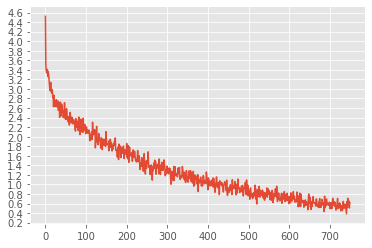

In [82]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

model = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

input = elle a cinq ans de moins que moi .
output = she s five years younger than i am . <EOS>


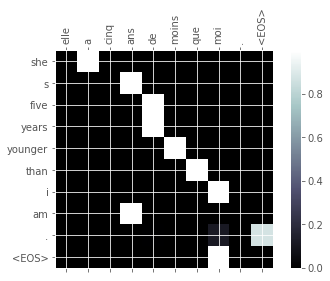

input = elle porte un pull bleu .
output = she is wearing a good student . <EOS>


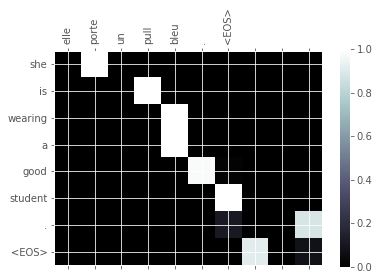

input = je reve de lire un livre .
output = i am reading for a book book . <EOS>


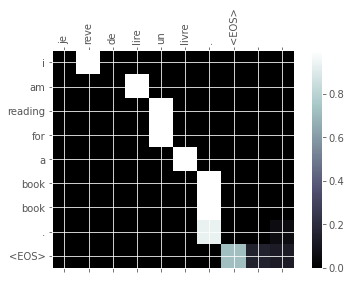

input = c est un devoir tres interessant mais lent .
output = he is a very hard but but . <EOS>


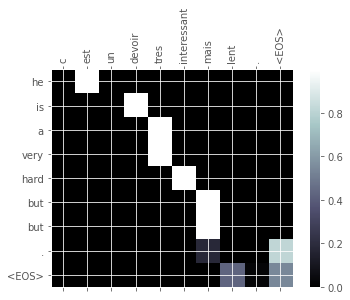

In [83]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle porte un pull bleu .")

evaluateAndShowAttention("je reve de lire un livre .")

evaluateAndShowAttention("c est un devoir tres interessant mais lent .")



input = c est un directeur plein de talent .
output = he s a talented talented . <EOS>


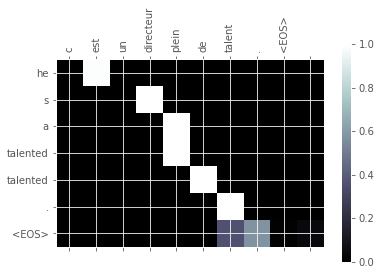

In [84]:
evaluateAndShowAttention("c est un directeur plein de talent .")


input = elle est comment l attention ici .
output = she is the stranger in here . <EOS>


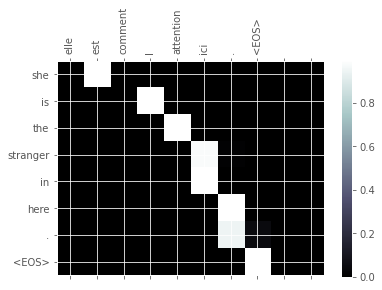

In [86]:
evaluateAndShowAttention("elle est comment l attention ici .")
